<h2>Controllable Factors Modeling Tuned for Area-Under-the-Curve (AUC)</h2>

In this notebook, we once again utilize Optuna to optimize for AUC using those variables that are deemed "controllable", in that it is reasonable to utilize an intervention to influence a patient's status for a given variable. The purpose of this is not necessarily maximum AUC for predictive purposes, but rather to understand which controllable variables may be most important, allowing us to identify where internventional efforts may be most impactful.

We utilize the TPESampler as our primary optimization algorithm, and utilize median pruining - that is, if the AUC result is worse than the current median, the test is scrapped. We compare versions of LogisticRegression, RandomForest, and XGBoost with tuned hyperparameters.

More detailed results can be found in our final report!

<h2>Note</h2>

These optimization loops can also take awhile, so please be patient! You will see (and read about why we did so in the report) that we decided to scrap one of the trials because we felt we already had enough information and a performative enough model.

In [7]:
import os
import sys
from pathlib import Path
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    log_loss,
    roc_auc_score

)
from sklearn.dummy import DummyClassifier
import shap

src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from expanding_scaler import global_expanding_standard_scaler_by_date

BASE_DIR = Path().resolve().parent

In [3]:
class OptimizerClassifier():
    def __init__(
            self,
            search_iter=5000,
            decision_threshold=0.5,
            scoring_metric='recall',
            xgb_objective='binary:logistic',
            random_state=42,
            n_jobs=-1
    ):
        self.search_iter = search_iter
        self.decision_threshold = decision_threshold
        self.scoring_metric = scoring_metric
        self.xgb_objective = xgb_objective
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.base_params = {
            "random_state": self.random_state,
            "n_jobs": self.n_jobs,
        }
        self.scorer = self._make_scorer_cust(self.scoring_metric)
        self.binary_vars = None
        self.date_col = None
        self.cv = None
        self.scaled_data = {}
        self.best_estimator = None
        self.best_score = None
        self.best_params = None
        self.best_use_balance = None

    def _make_scorer_cust(self, scoring_metric: str):
        if scoring_metric in ['logloss', 'mlogloss']:
            return log_loss
        # Uses 1 - accuracy to align with XGBoost error.
        elif scoring_metric in ['error', 'merror']:
            return lambda y_true, y_pred: 1 - (accuracy_score(y_true, y_pred))
        elif scoring_metric == "recall":
            return recall_score
        elif scoring_metric == "precision":
            return precision_score
        elif scoring_metric == "auc":
            return roc_auc_score
        else:
            raise ValueError(f"Unsupported scoring metric: {scoring_metric}")
    
    def _get_scaled_train_test_groups(self, X, y):

        order_idx = X[self.date_col].sort_values().index
        X_sorted = X.loc[order_idx]

        cont_cols = [c for c in X.columns if c not in self.binary_vars and c != self.date_col]
                
        if self.cv is None:
            
            tscv = TimeSeriesSplit(
                n_splits=3,
                test_size=int(round(X_sorted.shape[0] * 0.10, 0)),
                gap=0,
            )
            self.cv = list(tscv.split(X_sorted))

            for split, (train_index, test_index) in enumerate(self.cv):
                X_train, X_test = X_sorted.iloc[train_index], X_sorted.iloc[test_index]

                X_train_scaled = X_train.copy()
                X_test_scaled  = X_test.copy()

                X_train_scaled[cont_cols] = X_train_scaled[cont_cols].astype(float)
                X_test_scaled[cont_cols]  = X_test_scaled[cont_cols].astype(float)

                train_for_scaler = X_train_scaled[cont_cols + [self.date_col]]
                train_scaled_full, train_scaler_state = global_expanding_standard_scaler_by_date(
                    train_for_scaler,
                    date_col=self.date_col,
                    merge_cols=[self.date_col],
                    min_periods=0,
                    return_stats=True,
                )
                X_train_scaled.loc[train_scaled_full.index, cont_cols] = train_scaled_full[cont_cols]

                test_for_scaler = X_test_scaled[cont_cols + [self.date_col]]
                test_scaled_full = global_expanding_standard_scaler_by_date(
                    test_for_scaler,
                    date_col=self.date_col,
                    merge_cols=[self.date_col],
                    min_periods=0,
                    stats=train_scaler_state,
                    return_stats=False,
                )
                X_test_scaled.loc[test_scaled_full.index, cont_cols] = test_scaled_full[cont_cols]

                X_train_lr = X_train_scaled.drop(columns=[self.date_col])
                X_test_lr = X_test_scaled.drop(columns=[self.date_col])

                self.scaled_data[f'train_{split}'] = X_train_lr
                self.scaled_data[f'test_{split}'] = X_test_lr

            X_group_needs_scaling = X[cont_cols + [self.date_col]]
            X_group_scaled = global_expanding_standard_scaler_by_date(
                X_group_needs_scaling,
                date_col=self.date_col,
                merge_cols=[self.date_col],
                min_periods=0
            )

            X_group_scaled_full = X.copy()
            X_group_scaled_full[cont_cols] = X_group_scaled[cont_cols]

            X_group_scaled_no_date = X_group_scaled_full.drop(columns=[self.date_col])
            self.scaled_data['all'] = X_group_scaled_no_date

    def _eval_classifier(self, X, y, model_params, trial):

        if self.cv is None:
            raise ValueError('self.cv is not set.')
        
        order_idx = X[self.date_col].sort_values().index
        y_sorted = y.loc[order_idx]
        
        fold_scores = []
        for split, (train_index, test_index) in enumerate(self.cv):
            
            smote = SMOTE(random_state=self.random_state)
            X_train, y_train = smote.fit_resample(self.scaled_data[f'train_{split}'], y_sorted.iloc[train_index])

            X_test  = self.scaled_data[f'test_{split}']
            y_test = y_sorted.iloc[test_index]
            
            
            # We aren't using the pruining callback because it would interrupt the
            # k-fold cross-validation. Instead, we use early stopping as a parameter
            # of the model, and allow Optuna to then decide where to search next.
            model = self.ModelClass(**model_params)

            if self.ModelClass is XGBClassifier:
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_test, y_test)],
                    verbose=False
                )
            else:
                model.fit(X_train,y_train)
            # During training with an eval_set and early_stopping_rounds,
            # XGBoost tracks the validation score at each boosting round.
            # When validation stops improving for early_stopping_rounds
            # consecutive rounds, training halts and best_iteration is then
            # set to the boosting round (0-based index) with the best validation score.
            best_iter = getattr(model, "best_iteration", None)
            use_proba = self.scoring_metric in ("logloss", "mlogloss", "auc")

            if best_iter is not None:
                y_proba_test = model.predict_proba(X_test, iteration_range=(0, best_iter + 1))[:, 1]
            else:
                y_proba_test = model.predict_proba(X_test)[:, 1]
            
            # yhat_train = (y_proba_train >= decision_threshold).astype(int)
            yhat_test = (y_proba_test  >= self.decision_threshold).astype(int)

            if use_proba:
                fold_score = self.scorer(y_test, y_proba_test)
            else:
                fold_score = self.scorer(y_test, yhat_test)

            if self.ModelClass is XGBClassifier:
                trial.report(fold_score, step=split)
                if trial.should_prune():
                    raise optuna.TrialPruned()

            fold_scores.append(fold_score)
        
        return float(np.mean(fold_scores))

    def _run_optimization(self, X, y):

        self._get_scaled_train_test_groups(X, y)

        def __objective(trial: optuna.Trial) -> float:

            if self.cv is None or not isinstance(self.cv, list):
                raise ValueError('cv_splits is not set.')
            if X is None:
                raise ValueError('X is not set.')
            if y is None:
                raise ValueError('y is not set.')
            if self.ModelClass is None:
                raise ValueError('ModelClass is not set.')
            
            if self.ModelClass is XGBClassifier:
                neg = (y == 0).sum()
                pos = (y == 1).sum()
                balance_eq = neg / pos

                use_balance = trial.suggest_categorical("use_balance_weight", [True, False])
                model_params = {
                    **self.base_params,
                    "n_estimators": 3000,
                    "early_stopping_rounds": 50,
                    "objective": self.xgb_objective,
                    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
                    "max_depth": trial.suggest_int("max_depth", 3, 10),
                    "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 20.0, log=True),
                    "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                    "gamma": trial.suggest_float("gamma", 1e-9, 10.0, log=True),
                }
                if use_balance:
                    model_params["scale_pos_weight"] = balance_eq
            elif self.ModelClass is RandomForestClassifier:
                model_params = {
                    **self.base_params,
                    "bootstrap": True,
                    "n_estimators": trial.suggest_int("n_estimators", 10, 300),
                    "max_depth": trial.suggest_int("max_depth", 3, 10),
                    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
                    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                    "class_weight": trial.suggest_categorical("class_weight", ["balanced", None])
            }
            else:
                model_params = {
                    **self.base_params,
                    "max_iter": 1000,
                    # "solver": "liblinear",
                    "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
                    "C": trial.suggest_float("C", 1e-9, 10.0, log=True),
                    #"penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
                }
            

            score = self._eval_classifier(X, y, model_params, trial)

            return score
        
        if self.scoring_metric in ("logloss", "mlogloss", "error", "merror"):
            direction = "minimize"
        else:
            direction = "maximize"
        
        study = optuna.create_study(
            direction=direction,
            pruner=MedianPruner(n_min_trials=self.search_iter // 2),
            sampler=TPESampler(seed=self.random_state)
        )
        study.optimize(
                __objective,
            n_trials=self.search_iter
        )

        order_idx = X[self.date_col].sort_values().index
        X_all_scaled = self.scaled_data['all'].loc[order_idx]
        y_sorted = y.loc[order_idx]

        study_params = dict(study.best_params)

        use_balance = study_params.pop("use_balance_weight", None)
        best_model_params = {**self.base_params, **study_params}
        best_estimator = self.ModelClass(**best_model_params)
        best_estimator.fit(X_all_scaled, y_sorted)

        self.best_estimator = best_estimator
        self.best_score = study.best_value
        self.best_params = best_model_params
        self.best_use_balance = use_balance

    def fit_transform(
        self,
        X,
        y,
        date_col,
        binary_vars=None,
        model_type='xgb_clf'
    ):
        
        self.date_col = date_col
        self.binary_vars = binary_vars or []
        
        if model_type == 'xgb_clf':
            self.ModelClass = XGBClassifier
        elif model_type == 'lr':
            self.ModelClass = LogisticRegression
        elif model_type == 'rf':
            self.ModelClass = RandomForestClassifier
        else:
            raise ValueError(f"Model type {model_type} is not supported.")
        
        X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")
        X = X.dropna(subset=[self.date_col])

        self._run_optimization(X, y)

        return (self.best_estimator, self.best_score, self.best_params)

In [4]:
def load_and_preprocess(
    files_path: Path,
    chunk_size: int = 100_000,
    sample_frac: float = 1.0
):
    """
    Loads natality data in chunks, applies optional sampling, converts rf_ and ip_
    columns to numeric, creates aggregate RF/IP indicators, renames columns, and
    returns a numeric DataFrame with Maternal Morbidity as int.
    """
    first_cols = pd.read_csv(files_path, nrows=0).columns

    ld_cols = [c for c in first_cols if c.lower().startswith("ld_")]
    rf_cols = [c for c in first_cols if c.lower().startswith("rf_")]
    ip_cols = [c for c in first_cols if c.lower().startswith("ip_")]

    usecols = [
        "bmi", "meduc", "feduc", "precare", "previs", "cig_rec",
        "morbidity_reported", "bfacil", "pay", "attend", "me_pres", "me_rout",
        'date'] + ld_cols + rf_cols + ip_cols

    rename_map = {
        "bmi": "Body Mass Index",
        "meduc": "Mother Education",
        "feduc": "Father Education",
        "precare": "Pre-natal Care Begins",
        "previs": "Pre-natal Visits",
        "cig_rec": "Cigarette Smoking",
        "morbidity_reported": "Maternal Morbidity",
        "bfacil": "Facility",
        "pay": "Payment Method",
        "attend": "Medical Provider",
        "ld_indl": "Induction of Labor",
        "ld_augm": "Augmentation of Labor",
        "ld_ster": "Steriods Used",
        "ld_antb": "Antibiotics Used",
        "ld_chor": "Chorioamnionitis Present",
        "ld_anes": "Anesthesia Used",
        "me_pres": "Fetal Presentation at Delivery",
        "me_rout": "Final Route of Delivery",
        "date": "Date of Birth",
    }

    dfs = []
    reader = pd.read_csv(files_path, chunksize=chunk_size, usecols=usecols, low_memory=False)

    for chunk in reader:
        sampled = chunk.sample(frac=sample_frac, random_state=42)

        rf_present = [c for c in rf_cols if c in sampled.columns]
        ip_present = [c for c in ip_cols if c in sampled.columns]

        if rf_present:
            sampled[rf_present] = sampled[rf_present].apply(pd.to_numeric, errors="coerce").fillna(0)
        if ip_present:
            sampled[ip_present] = sampled[ip_present].apply(pd.to_numeric, errors="coerce").fillna(0)

        sampled["Risk Factor Present"] = (sampled[rf_present].sum(axis=1) > 0).astype(int)
        sampled["Infection Present"] = (sampled[ip_present].sum(axis=1) > 0).astype(int)

        sampled.drop(columns=rf_present + ip_present, inplace=True)

        sampled.rename(columns=rename_map, inplace=True)
        dfs.append(sampled)

    df = pd.concat(dfs, ignore_index=True)

    df = df.dropna()
    df["Maternal Morbidity"] = df["Maternal Morbidity"].astype(int)

    return df

In [5]:
path = BASE_DIR / 'data_main' / 'natality_aligned_10pct_sample.csv'

clean_df = load_and_preprocess(path)

clean_df

,Facility,Mother Education,Father Education,Pre-natal Care Begins,Pre-natal Visits,Cigarette Smoking,Body Mass Index,Induction of Labor,Augmentation of Labor,Steriods Used,...,Chorioamnionitis Present,Anesthesia Used,Fetal Presentation at Delivery,Final Route of Delivery,Maternal Morbidity,Medical Provider,Payment Method,Date of Birth,Risk Factor Present,Infection Present
0,1.0,7.0,3.0,6.0,5.0,0.0,99.900002,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0,2.0,2.0,2020-02-03,0,0
3,1.0,3.0,3.0,3.0,7.0,0.0,19.000000,1.0,0.0,0.0,...,0.0,1.0,1.0,3.0,0,1.0,8.0,2020-01-27,0,0
4,1.0,5.0,5.0,2.0,12.0,0.0,21.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0,1.0,6.0,2019-12-30,0,0
6,1.0,7.0,7.0,6.0,5.0,0.0,22.200001,1.0,0.0,0.0,...,0.0,1.0,1.0,4.0,0,1.0,1.0,2020-01-27,0,0
10,1.0,6.0,6.0,2.0,10.0,0.0,30.400000,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0,1.0,2.0,2020-01-13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4157614,1.0,6.0,6.0,2.0,10.0,0.0,24.900000,0.0,0.0,0.0,...,0.0,1.0,1.0,4.0,0,1.0,2.0,2019-01-28,0,0
4157615,1.0,5.0,5.0,3.0,15.0,0.0,30.100000,1.0,0.0,0.0,...,0.0,0.0,1.0,4.0,1,1.0,2.0,2019-01-28,1,0
4157616,1.0,5.0,3.0,1.0,12.0,0.0,27.799999,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0,1.0,2.0,2019-02-04,0,0
4157617,1.0,3.0,3.0,5.0,6.0,0.0,35.400002,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0,1.0,3.0,2019-02-04,0,0


In [6]:
clean_df.shape

(2532842, 21)

In [6]:
cat_cols = [c for c in clean_df.columns if clean_df[c].nunique() < 10]

oh_df = clean_df.copy()

oh_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_one_hot = pd.DataFrame(oh_encoder.fit_transform(oh_df[cat_cols]), columns=oh_encoder.get_feature_names_out(cat_cols))
X_one_hot = oh_df.drop(columns=cat_cols).merge(X_one_hot, left_index=True, right_index=True)

X_cat = clean_df.drop(columns=["Maternal Morbidity"])
y = clean_df["Maternal Morbidity"]

binary_vars_oh = [var for var in X_one_hot.columns if X_one_hot[var].nunique() == 2]
binary_vars_cat = [var for var in X_cat.columns if X_cat[var].nunique() == 2]

In [7]:
dummy = DummyClassifier(strategy='uniform')
dummy2 = DummyClassifier(strategy='stratified')

dummy.fit(X_cat.drop('Date of Birth', axis=1), y)
dummy2.fit(X_cat.drop('Date of Birth', axis=1), y)

y_pred = dummy.predict(X_cat)
y_pred2 = dummy2.predict(X_cat)

print(f"Dummy AUC:  {roc_auc_score(y, y_pred,  average='macro')}")
print(f"Dummy2 AUC: {roc_auc_score(y, y_pred2, average='macro')}")

Dummy AUC:  0.49825588646509444
Dummy2 AUC: 0.49989175965509364


In [8]:
optimizer_rf = OptimizerClassifier(
    search_iter=100,
    random_state=42,
    decision_threshold=0.5,
    scoring_metric='auc',
    xgb_objective='binary:logistic',
    n_jobs=-1
)

best_rf_model, best_rf_score, best_rf_params = optimizer_rf.fit_transform(
    X_cat,
    y,
    date_col='Date of Birth',
    binary_vars=binary_vars_cat,
    model_type='rf'
)

[I 2025-12-07 17:30:41,297] A new study created in memory with name: no-name-4bb8af3b-6e40-4b0d-9921-3631f7a42b6e
[I 2025-12-07 17:34:44,288] Trial 0 finished with value: 0.5773352098730112 and parameters: {'n_estimators': 118, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5773352098730112.
[I 2025-12-07 17:35:39,541] Trial 1 finished with value: 0.5634990519567918 and parameters: {'n_estimators': 26, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8, 'class_weight': None}. Best is trial 0 with value: 0.5773352098730112.
[I 2025-12-07 17:39:07,276] Trial 2 finished with value: 0.5750207205574743 and parameters: {'n_estimators': 252, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'class_weight': None}. Best is trial 0 with value: 0.5773352098730112.
[I 2025-12-07 17:41:26,352] Trial 3 finished with value: 0.5780599052959399 and parameters: {'n_estimators': 135, 'max_depth': 5, 'min_s

In [9]:
optimizer_xgb = OptimizerClassifier(
    search_iter=100,
    random_state=42,
    decision_threshold=0.5,
    scoring_metric='auc',
    xgb_objective='binary:logistic',
    n_jobs=-1
)

best_xgb_model, best_xgb_score, best_xgb_params = optimizer_xgb.fit_transform(
    X_cat,
    y,
    date_col='Date of Birth',
    binary_vars=binary_vars_cat,
    model_type='xgb_clf'
)

[I 2025-12-07 21:05:13,223] A new study created in memory with name: no-name-bc0ea461-1c0b-413a-8ddb-2ea5c8843666
[I 2025-12-07 21:06:48,552] Trial 0 finished with value: 0.6225435963837179 and parameters: {'use_balance_weight': False, 'learning_rate': 0.06504856968981275, 'max_depth': 7, 'min_child_weight': 0.8890398459575589, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'gamma': 0.4589458612326473}. Best is trial 0 with value: 0.6225435963837179.
[I 2025-12-07 21:13:01,923] Trial 1 finished with value: 0.6151414651535411 and parameters: {'use_balance_weight': False, 'learning_rate': 0.001124579825911934, 'max_depth': 10, 'min_child_weight': 10.779361932748845, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 6.824095540630416e-08}. Best is trial 0 with value: 0.6225435963837179.
[I 2025-12-07 21:15:48,415] Trial 2 finished with value: 0.5986997473696235 and parameters: {'use_balance_weight': False, 'learning_rate': 0.0117484

In [10]:
optimizer_lr = OptimizerClassifier(
    search_iter=100,
    random_state=42,
    decision_threshold=0.5,
    scoring_metric='auc',
    xgb_objective='binary:logistic',
    n_jobs=-1
)

best_lr_model, best_lr_score, best_lr_params = optimizer_lr.fit_transform(
    X_one_hot,
    y,
    date_col='Date of Birth',
    binary_vars=binary_vars_oh,
    model_type='lr'
)

[I 2025-12-08 02:23:33,272] A new study created in memory with name: no-name-b72d1f55-09a8-46ee-b322-54d9cf4ae9ae
/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
[I 2025-12-08 02:24:07,108] Trial 0 finished with value: 0.520120883

In [21]:
X_lr_design  = optimizer_lr.scaled_data["all"]
X_rf_design  = optimizer_rf.scaled_data["all"]
X_xgb_design = optimizer_xgb.scaled_data["all"]

feat_cols = X_rf_design.columns 

# LR importances at coef-dummy level
lr_raw_imp = np.abs(best_lr_model.coef_[0])
lr_imp_series = pd.Series(lr_raw_imp, index=X_lr_design.columns)

# Take mean coef of each dummy variable to get feature importance
# aligned with XGB and RF
agg_lr_imp = {}
for col in X_cat.columns:
    if col in cat_cols:
        dummy_cols = [c for c in lr_imp_series.index if c.startswith(col + "_")]
        if dummy_cols:
            agg_lr_imp[col] = lr_imp_series[dummy_cols].mean()
        else:
            agg_lr_imp[col] = 0.0
    else:
        agg_lr_imp[col] = lr_imp_series.get(col, 0.0)

feat_imp = pd.DataFrame({"feature": feat_cols})
feat_imp["LR"] = feat_imp["feature"].map(agg_lr_imp)
feat_imp["RF"]  = best_rf_model.feature_importances_
feat_imp["XGB"] = best_xgb_model.feature_importances_

# Normalize each column
for col in ["LR", "RF", "XGB"]:
    max_val = feat_imp[col].max()
    if max_val != 0:
        feat_imp[col] = feat_imp[col] / max_val

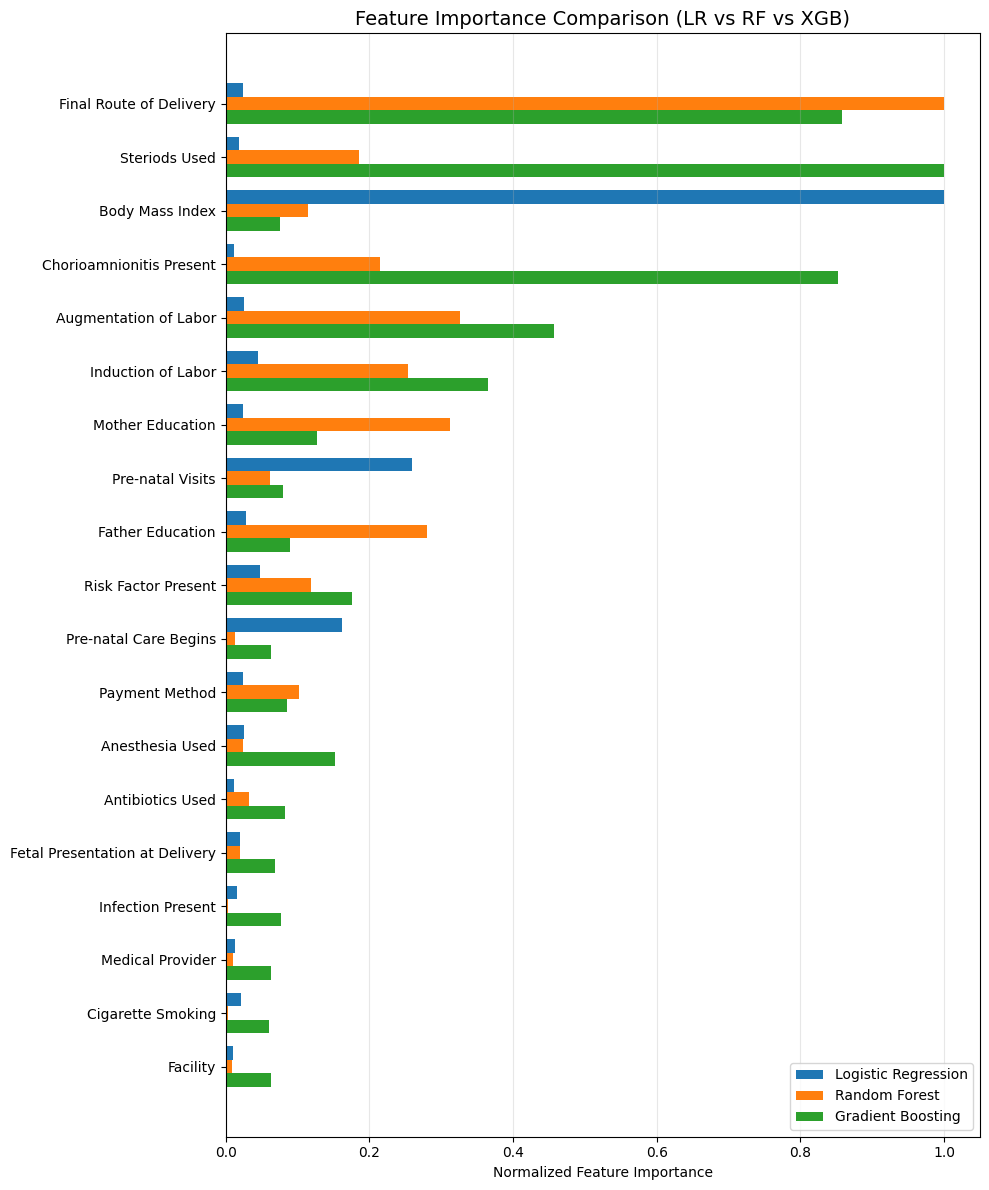

In [22]:
feat_imp["mean_importance"] = feat_imp[["LR", "RF", "XGB"]].mean(axis=1)
top = feat_imp.sort_values("mean_importance", ascending=False).head(20)

plt.figure(figsize=(10, 12))

bar_width = 0.25
x = np.arange(len(top))

plt.barh(x - bar_width, top["LR"], height=bar_width, label="Logistic Regression")
plt.barh(x, top["RF"], height=bar_width, label="Random Forest")
plt.barh(x + bar_width, top["XGB"], height=bar_width, label="Gradient Boosting")

plt.yticks(x, top["feature"])
plt.gca().invert_yaxis()
plt.xlabel("Normalized Feature Importance")
plt.title("Feature Importance Comparison (LR vs RF vs XGB)", fontsize=14)
plt.legend()
plt.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
def shap_bar_plot(model, X_test, max_display=20):
    shap.initjs()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(
        shap_values,
        X_test,
        plot_type="bar",
        max_display=max_display
    )
    return

def plot_partial_dependence_grid(model, X, feature_list, n_rows=3, n_cols=3):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))
    axes = axes.ravel()

    for ax, feat in zip(axes, feature_list):
        if feat not in X.columns:
            ax.set_visible(False)
            continue

        PartialDependenceDisplay.from_estimator(
            model,
            X,
            [feat],
            ax=ax,
        )

    # Hide any unused axes
    for j in range(len(feature_list), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


Plotting partial dependence plots (XGBoost)...


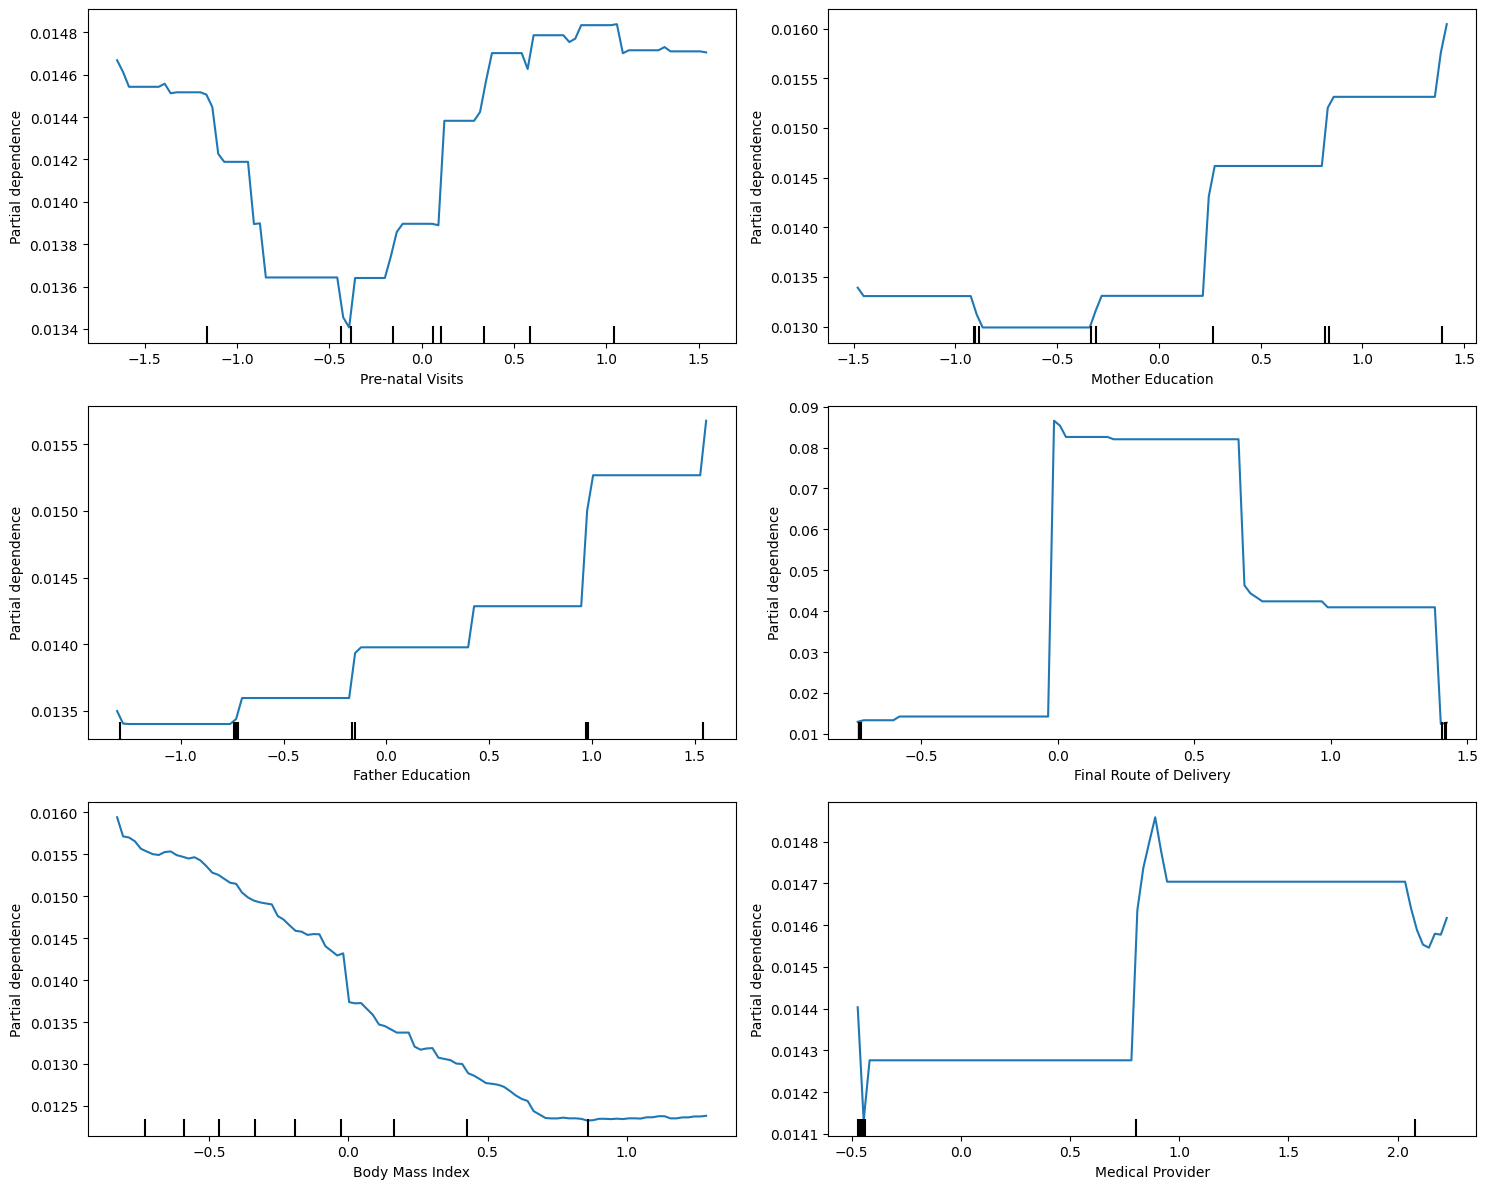

In [24]:
pdp_features = [
    "Pre-natal Visits",
    "Mother Education",
    "Father Education",
    "Final Route of Delivery",
    # "Payment Method",
    "Body Mass Index",
    "Medical Provider",
    # "Risk Factor Present",
]
pdp_features = [f for f in pdp_features if f in feat_cols]

if pdp_features:
    print("\nPlotting partial dependence plots (XGBoost)...")
    plot_partial_dependence_grid(
        best_xgb_model,
        optimizer_xgb.scaled_data["all"],
        pdp_features,
        n_rows=3,
        n_cols=2
    )

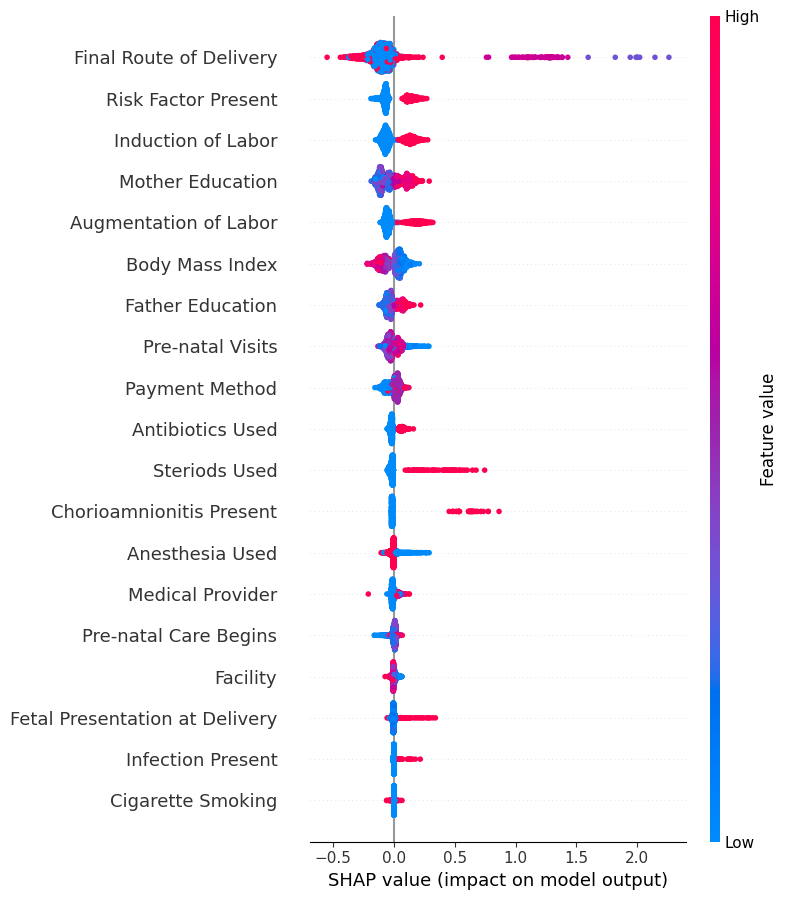

In [26]:
sampled_for_shap = optimizer_xgb.scaled_data["all"].sample(2000, random_state=42)

# SHAP analysis
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(sampled_for_shap)

# Global importance
shap.summary_plot(shap_values, sampled_for_shap)